#### Case 1: Isobaric evaporation of liquid hydrogen in a 4.89 $m^3$ spherical tank experiments.

This notebook sets up the isobaric evaporation of liquid hydrogen ($LH_2$) in a 4.89 $m^3$ storage tank. A high liquid filling, high heat ingress scenario from Hasan (1991) is considered. This tank is representative of lab-scale tanks used for cryogen evaporation experiments that measure boil-off rates and thermal stratification.

In [187]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

from scipy.integrate import simps

#### Setup tank and cryogen properties

In [188]:
# LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 2.106 # Internal diameter / m
d_o = 2.106+2.08e-3   # External diameter / m
T_air = 350 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.01063 # W/m2/K up to 0.1-0.2
U_V = 0.01063 # W/m2/K

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 0 # W, 

# Spherical tank volume
V_tank = 4.89 #m^3

# Initial liquid filling / Dimensionless
LF = 0.7

# Specify tank operating pressure
P = 117e3 # Pa

Geo_v1 = "spherical"
Geo_l1 = "spherical"

idz = 0.08

timer = []
nodes = []
end_temps = []
top_temps=[]
qvls = []

while idz>0.0045:
    # Initialize large-scale tank
    small_tank1 = Tank(d_i, d_o, V_tank, Geo_v1, Geo_l1,LF)
    small_tank1.set_HeatTransProps(U_L, U_V, T_air, Q_b, Q_roof, eta_w = 0.7)

    small_tank2 = Tank(d_i, d_o, V_tank, Geo_v1, Geo_l1,LF)
    small_tank2.set_HeatTransProps(U_L, U_V, T_air, Q_b, Q_roof, eta_w = 0.7)

    # Initialise cryogen
    hydrogen1 = Cryogen(name = "hydrogen")
    hydrogen1.set_coolprops(P)

    hydrogen2 = Cryogen(name = "hydrogen")
    hydrogen2.set_coolprops(P)

    # Set cryogen
    small_tank1.cryogen = hydrogen1
    small_tank2.cryogen = hydrogen2

    # Minimum number of hours to achieve steady state 
    tau_h1 = (np.floor(small_tank1.tau / 3600) + 1)

    # Calculate boil-off rate
    BOR1 = (small_tank1.b_l_dot * 24 * 3600) / (small_tank1.V * small_tank1.LF * small_tank1.cryogen.rho_L)

    # Define vertical spacing
    dz = idz

    # Calculate number of nodes
    n_z = 1 + int(np.round(small_tank1.l_V/dz, 0))

    # Define dimensionless computational grid
    small_tank1.z_grid = np.linspace(0, 1, n_z)
    small_tank2.z_grid = np.linspace(0, 1, n_z)

    # Insulated roof
    small_tank1.U_roof = 0
    small_tank2.U_roof = 0

    # Define evaporation time as twice as the transient period
    evap_time = 3600*tau_h1*0.5

    # Time step to record data, relevant for plotting integrated quantities
    # such as the vapour to liquid heat transfer rate, Q_VL
    small_tank1.time_interval = 60
    small_tank2.time_interval = 60

    # Time step to plot each vapour temperature profile
    small_tank1.plot_interval = evap_time/6
    small_tank2.plot_interval = evap_time/6

    timey = %timeit -o -r 1 small_tank1.evaporate(evap_time)
    timer.append(timey.average)

    # Simulate the evaporation
    small_tank2.evaporate(evap_time)

    nodes.append(n_z)
    end_temps.append(small_tank2.sol.y[1:,-1])
    top_temps.append(small_tank2.sol.y[-1,:])
    qvls.append(small_tank2.data['Q_VL'])

    idz*=0.75

/home/aeb23/IRP/CryoEvap/notebooks/../cryoevap/storage_tanks/tank.py:472: RuntimeWarning: divide by zero encountered in divide
  vz = self.v_z*(l_L[i]/zed)*(2*self.d_i/2 - l_L[i])/(2*self.d_i/2 - zed)


217 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
376 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
408 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
558 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
826 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.46 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
17.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
30.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [189]:
nodes

[11, 14, 18, 24, 31, 41, 55, 73, 97, 128, 171]

In [190]:
col=['steelblue','firebrick','black']

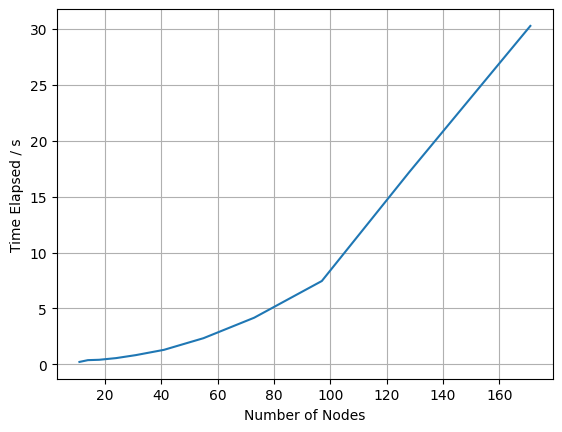

In [191]:
plt.plot(nodes,timer)
plt.xlabel('Number of Nodes')
plt.ylabel('Time Elapsed / s')
#plt.title('Time to simulate 1 hr vs Number of Nodes')
plt.grid(True)

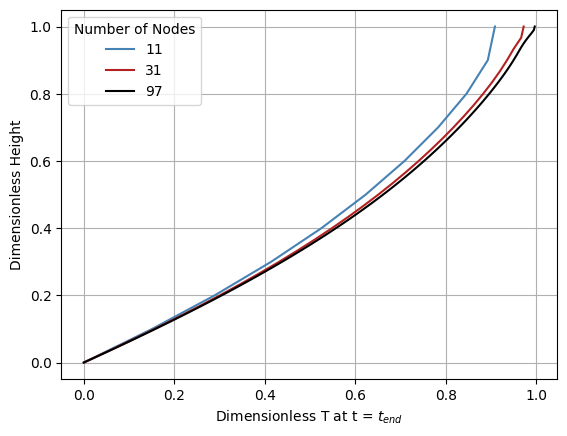

In [192]:
for i in range(0,len(end_temps),4):
    plt.plot((end_temps[i]-end_temps[i][0])/(end_temps[-1][-1]-end_temps[i][0]),np.linspace(0, 1, nodes[i]),label=nodes[i],color=col[i//4])
plt.legend()
plt.xlabel('Dimensionless T at t = $t_{end}$')
plt.ylabel('Dimensionless Height')
plt.legend(title='Number of Nodes')
plt.grid(True)

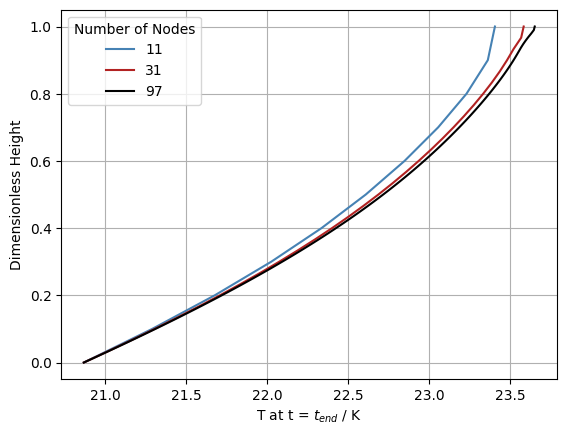

In [193]:
for i in range(0,len(end_temps),4):
    plt.plot((end_temps[i]),np.linspace(0, 1, nodes[i]),label=nodes[i],color=col[i//4])
plt.legend()
plt.xlabel('T at t = $t_{end}$ / K')
plt.ylabel('Dimensionless Height')
plt.legend(title='Number of Nodes')
plt.grid(True)

In [194]:
end_temps[-1][-1]

23.66398695290858

In [195]:
end_temps[-2][-1]

23.653653228484703

Text(0.5, 1.0, 'Mean Difference in Temperature vs Number of Nodes')

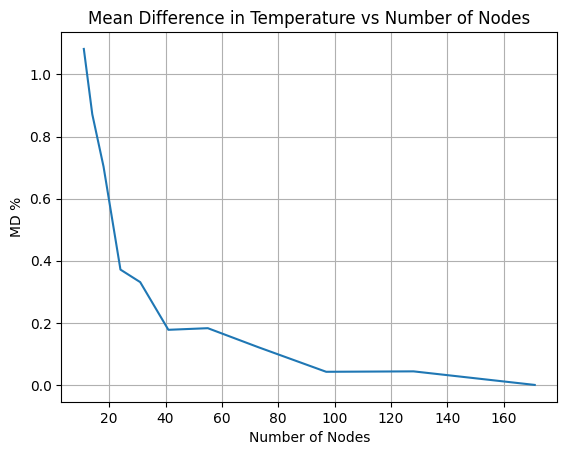

In [196]:
correct = end_temps[-1]
MD=[]
for i in end_temps:
    MD.append(np.average(abs(correct[-1]-i[-1])/correct[-1])*100)
plt.plot(nodes,MD)#,nodes,(correct[-1]*0.0003)*np.ones_like(nodes),'--')
plt.grid(True)
plt.ylabel('MD %')
plt.xlabel('Number of Nodes')
plt.title('Mean Difference in Temperature vs Number of Nodes')
#plt.annotate(f'Number of nodes used for $LF_{0}$ = {LF*100}%',(30,0.34),xytext=(30,0.41),arrowprops=dict(arrowstyle='->'))

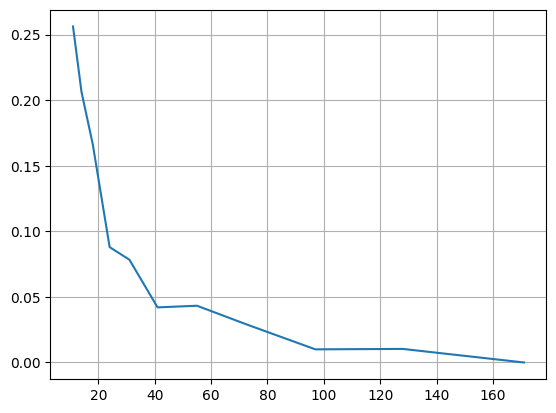

In [197]:
normet = []
et = end_temps[-1]
for i in end_temps:
    normet.append(np.linalg.norm(et[-1]-i[-1]))
plt.plot(nodes, normet)
plt.grid(True)

Text(0.5, 0, 'Number of Nodes')

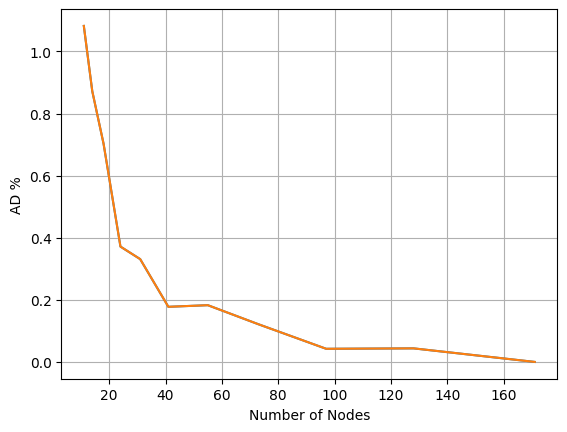

In [198]:
tcorrect = end_temps[-1]
ADET=[]
for i in end_temps:
    ADET.append(abs(tcorrect[-1]-i[-1])/tcorrect[-1] * 100)
plt.plot(nodes,ADET,nodes,MD)
plt.grid(True)
plt.ylabel('AD %')
plt.xlabel('Number of Nodes')

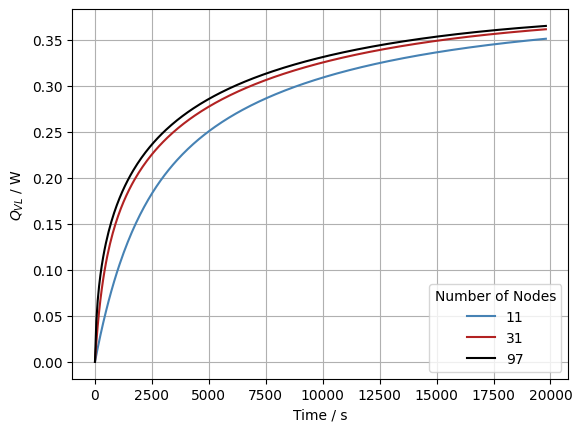

In [199]:
for i in range(0,len(nodes),4):
    plt.plot(np.linspace(0,evap_time,len(qvls[i])),qvls[i],label=nodes[i],color=col[i//4])
plt.legend(title='Number of Nodes')
plt.ylabel('$Q_{VL}$ / W')
plt.xlabel('Time / s')
plt.grid(True)

Text(0.5, 1.0, 'Mean Difference in $Q_{VL}$ vs Number of Nodes')

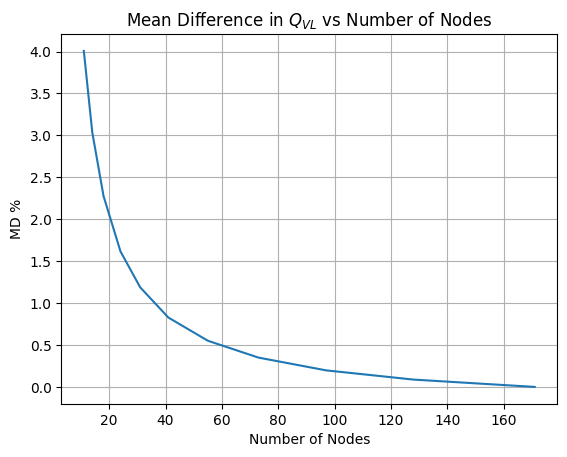

In [200]:
qcorrect = qvls[-1]
MDQ=[]
for i in qvls:
    MDQ.append(np.average(abs(qcorrect[-1]-i[-1])/qcorrect[-1])*100)
plt.plot(nodes,MDQ)#,nodes,(qcorrect[-1]*0.02)*np.ones_like(nodes),'--')
plt.grid(True)
plt.xlabel('Number of Nodes')
plt.ylabel('MD %')
plt.title('Mean Difference in $Q_{VL}$ vs Number of Nodes')
#plt.annotate(f'Number of nodes used for $LF_{0}$ = {LF*100}%',(30,1.0),xytext=(30,2.01),arrowprops=dict(arrowstyle='->'))

Text(0.5, 0, 'Number of Nodes')

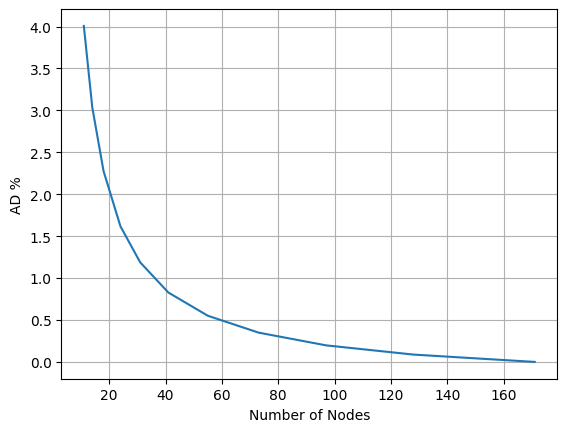

In [201]:
q2correct = qvls[-1]
ADQ=[]
for i in qvls:
    ADQ.append(abs(q2correct[-1]-i[-1])/q2correct[-1] * 100)
plt.plot(nodes,ADQ)
plt.grid(True)
plt.ylabel('AD %')
plt.xlabel('Number of Nodes')

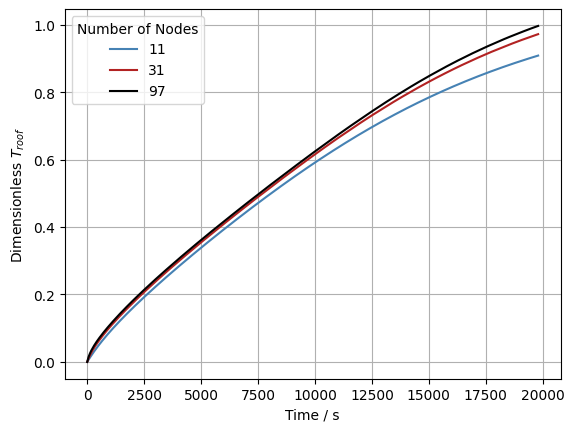

In [202]:
for i in range(0,len(nodes),4):
    plt.plot(np.linspace(0,evap_time,len(top_temps[i])),(top_temps[i]-top_temps[i][0])/(top_temps[-1][-1]-top_temps[i][0]),label=nodes[i],color=col[i//4]) #(end_temps[i]-end_temps[i][0])/(end_temps[-1][-1]-end_temps[i][0])
plt.legend(title='Number of Nodes')
plt.xlabel('Time / s')
plt.ylabel('Dimensionless $T_{roof}$')
plt.grid(True)

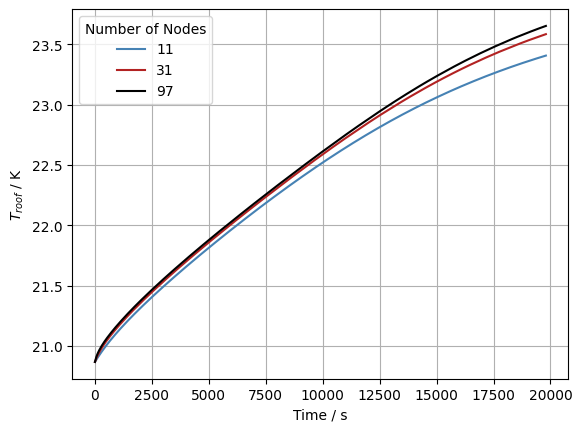

In [203]:
for i in range(0,len(nodes),4):
    plt.plot(np.linspace(0,evap_time,len(top_temps[i])),top_temps[i],label=nodes[i],color=col[i//4])
plt.xlabel('Time / s')
plt.ylabel('$T_{roof}$ / K')
plt.grid(True)
plt.legend(title='Number of Nodes')

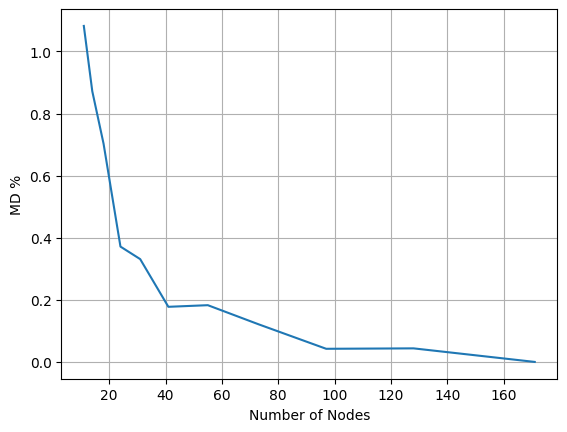

In [204]:
ecorrect = top_temps[-1]
MDTT=[]
for i in top_temps:
    MDTT.append(np.average(abs(ecorrect[-1]-i[-1])/ecorrect[-1])*100)
plt.plot(nodes,MDTT)#,nodes,MD)
plt.xlabel('Number of Nodes')
plt.ylabel('MD %')
plt.grid(True)
#plt.annotate(f'Number of nodes used for $LF_{0}$ = {LF*100}%',(30,0.03),xytext=(30,0.041),arrowprops=dict(arrowstyle='->'))

Text(0.5, 0, 'Number of Nodes')

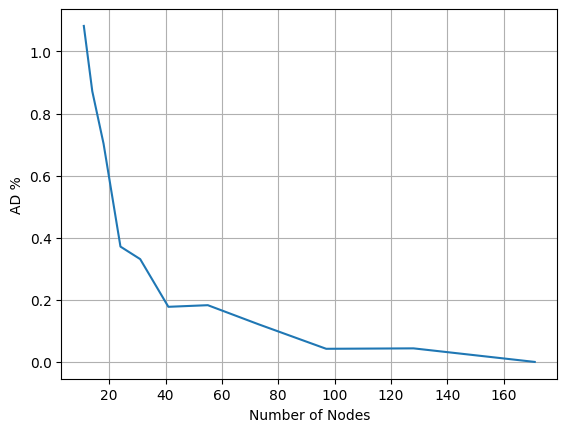

In [205]:
t2correct = top_temps[-1]
ADTT=[]
for i in top_temps:
    ADTT.append(abs(t2correct[-1]-i[-1])/t2correct[-1] * 100)
plt.plot(nodes,ADTT)
plt.grid(True)
plt.ylabel('AD %')
plt.xlabel('Number of Nodes')

Calculate initial evaporation rate and transient period

#### Simulation setup and execution

#### Visualisation of results

#### Vapour temperature

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

#### Plot liquid volume

In [206]:
small_tank1.data["Pressure"] = np.ones_like(small_tank1.data["B_L"])*P
air = P*(V_tank*(1-LF))/(8.314*hydrogen1.T_sat)
for i in range(1,len(small_tank1.data["B_L"])):
    small_tank1.data["Pressure"][i] = ((simps(small_tank1.data["B_L"][:i])*(1000/2) +air)*8.314*small_tank1.data["Tv_avg"][i])/(V_tank - small_tank1.data["V_L"][i])

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [207]:
# Import pandas 
import pandas as pd

In [208]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(small_tank1.data)
# Save file to the current working directory
df_evap.to_csv('LN2_small_m3.csv')

In [209]:
MD=[]
for i in [cc,c,mc,mf,f,ff,fff,ffff,fffff]:
    MD.append(np.average(ffffff['Q_VL'])-np.average(i['Q_VL']))
plt.plot([12,15,20,30,58,64,96,115,144],MD,label='Data')
percentdiff = np.average(ffffff['Q_VL'])-np.average(ffffff['Q_VL']-ffffff['Q_VL']*0.04)
plt.plot([12,15,20,30,58,64,96,115,144],percentdiff*np.ones(9),'--',label='4\% difference')
plt.plot(np.ones(10)*30,np.linspace(0,0.01,10),'--')
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Difference')


NameError: name 'cc' is not defined

#### References



Hasan, M., Lin, C. and Van Dresar, N. (1991). Self-Pressurization of a Flightweight Liquid Hydrogen Storage Tank Subjected to Low Heat Flux. [online] Available at: https://ntrs.nasa.gov/api/citations/19910011011/downloads/19910011011.pdf [Accessed 2 Jul. 2024].

Wang, Z. and Mérida, W. (2024). Thermal performance of cylindrical and spherical liquid hydrogen tanks. International Journal of Hydrogen Energy, 53, pp.667–683. doi:https://doi.org/10.1016/j.ijhydene.2023.11.287.